# Prediction of the outcome (converters vs non-converters) based on CNV parameters

Two predictive models were developed to distinguish between converters (n=302) and non-converters (n=75) based on a set of CNV parameters. The models chosen for this analysis were logistic regression and random forest. Logistic regression was selected due to its simplicity, interpretability, and effectiveness in binary classification tasks, making it suitable for identifying key predictors that distinguish between the two groups. Random forest was chosen because of its ability to capture complex interactions between features, and its robustness against overfitting, which makes it suitable for exploring more complex relationships within the data.


In [20]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline

sys.path.append(os.path.abspath(os.path.join('..')))
from scripts import create_individual_stat, merge_genetic_and_clinical

In [21]:
# Load the data
data = pd.read_csv('../results/merged_per_individual_annotations.csv')

In [22]:
# Set the index
data.index = data['ID']

# Convert the phenotype to binary
data['Phenotype_2'] = data['Phenotype_2'].map({'non-converter': 0, 'converter': 1})

# Drop the rows with missing values
data.dropna(subset=['Phenotype_2'], inplace=True)

# Create the predictors and target
predictors = ['Avg_copy_number_DEL', 'Avg_copy_number_DUP', 
              'Brain_rare_length_DEL', 'Brain_rare_length_DUP',
              'Long_brain_rare_length_DEL', 'Long_brain_rare_length_DUP',
              'Long_rare_length_DEL', 'Long_rare_length_DUP',
              'NB_brain_genes_rare_DEL', 'NB_brain_genes_rare_DUP',
              'NB_brain_rare_DEL', 'NB_brain_rare_DUP', 'NB_genes_rare_DEL',
              'NB_genes_rare_DUP', 'NB_long_brain_rare_DEL', 
              'NB_long_brain_rare_DUP', 'NB_long_rare_DEL', 
              'NB_long_rare_DUP', 'NB_rare_DEL', 'NB_rare_DUP', 
              'Rare_length_DEL', 'Rare_length_DUP']
target = 'Phenotype_2'

# Create the X and y
X = data[predictors]
y = data[target]

# Set inf values to 0 
inf_mask = np.isinf(X[['Avg_copy_number_DEL']])
X.loc[inf_mask['Avg_copy_number_DEL'], 'Avg_copy_number_DEL'] = 0

In [24]:
# Illustrate the data imbalance
y.value_counts()

Phenotype_2
1.0    302
0.0     75
Name: count, dtype: int64

Due to the imbalanced nature of the dataset (with a significantly higher number of converters compared to non-converters), specific strategies were employed to ensure robust model performance and avoid bias towards the majority class. Cross-validation with class weights was utilized to address this imbalance. In the logistic regression model, class weights were adjusted to provide greater emphasis on the minority class (non-converters) during model training, thereby ensuring that the predictive models accurately identified instances of both converters and non-converters. For the random forest model, the class weights were similarly adjusted to enhance sensitivity towards the minority class.  

To effectively validate the model’s performance and prevent overfitting, a stratified cross-validation approach was employed with 70% of the data allocated for training and 30% for testing. Stratified cross-validation was chosen to maintain the original class distribution in each fold, ensuring that each fold had a representative sample of both converters and non-converters. This approach provided a more reliable evaluation of the model's predictive power across different subsets of data.

Model Performance Summary:
                 Model   F1 Mean  F1 Variance  Precision Mean  \
0  Logistic Regression  0.711425     0.000585        0.812174   
1        Random Forest  0.826634     0.001209        0.809783   

   Precision Variance  Recall Mean  Recall Variance  ROC AUC Mean  \
0            0.000592     0.635683         0.002150      0.493927   
1            0.001179     0.844481         0.001463      0.516266   

   ROC AUC Variance  
0          0.004655  
1          0.018411  


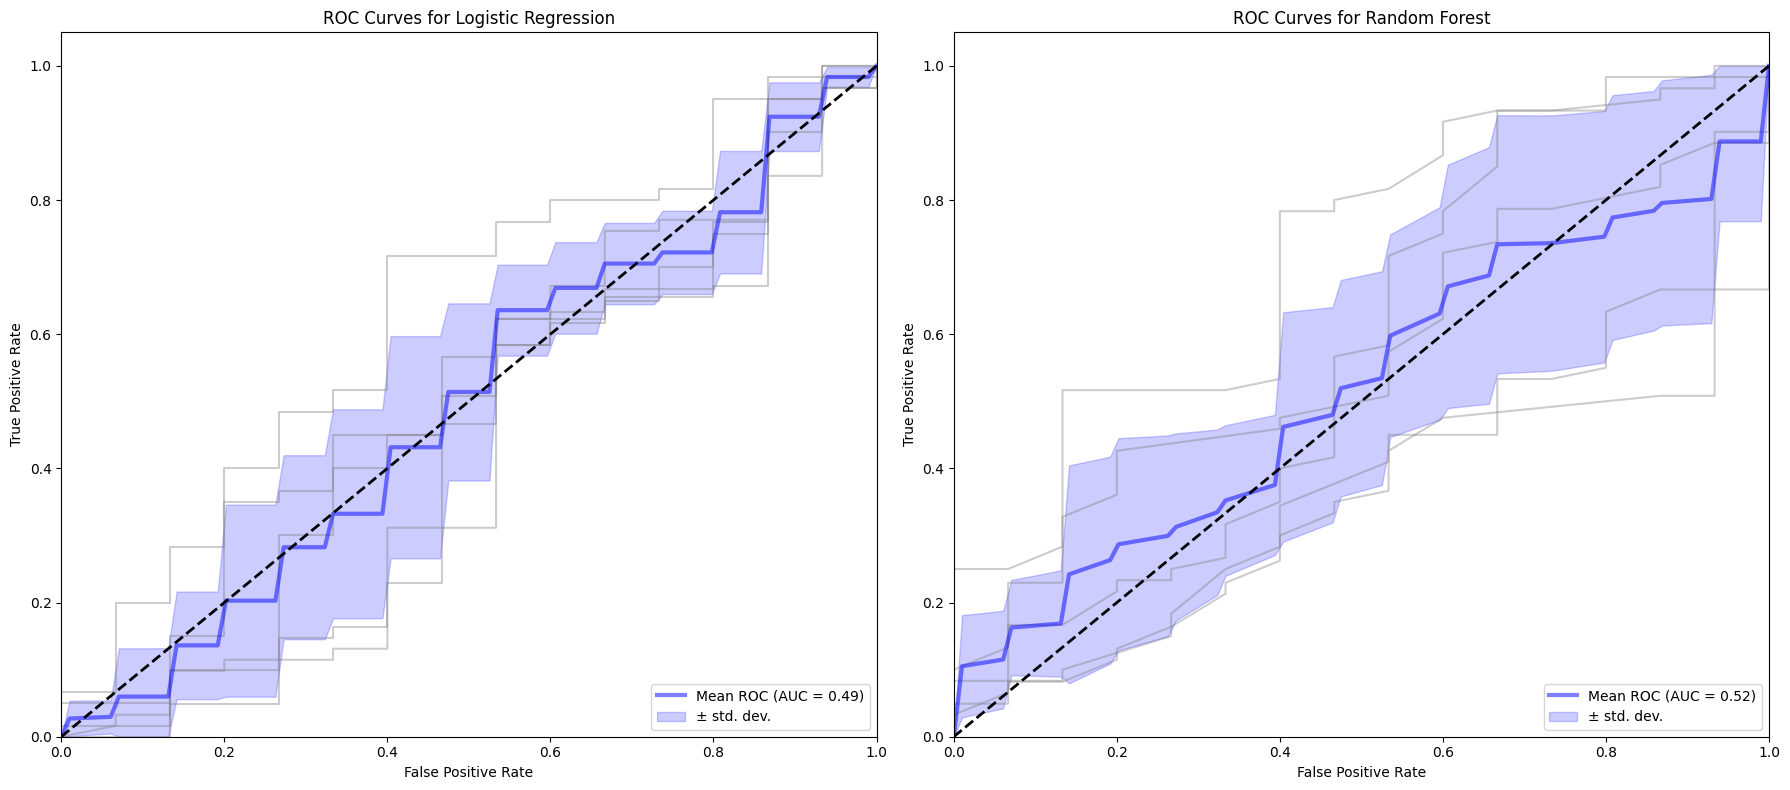

Feature Importances for Random Forest:
Rare_length_DEL               0.121987
Rare_length_DUP               0.119606
Avg_copy_number_DEL           0.116953
Avg_copy_number_DUP           0.108953
NB_genes_rare_DUP             0.089134
NB_genes_rare_DEL             0.079860
NB_rare_DUP                   0.071092
NB_rare_DEL                   0.068891
Brain_rare_length_DEL         0.057646
Brain_rare_length_DUP         0.041272
NB_brain_rare_DUP             0.033144
NB_brain_genes_rare_DEL       0.031200
NB_brain_rare_DEL             0.028358
NB_brain_genes_rare_DUP       0.025216
NB_long_brain_rare_DUP        0.001748
Long_rare_length_DEL          0.001490
Long_brain_rare_length_DUP    0.001276
NB_long_rare_DUP              0.001095
Long_rare_length_DUP          0.000898
NB_long_rare_DEL              0.000182
Long_brain_rare_length_DEL    0.000000
NB_long_brain_rare_DEL        0.000000
dtype: float64


In [23]:
# Initialize and configure models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced',
                                              max_iter=1000, 
                                              random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced',
                                            n_estimators=100, 
                                            random_state=42)
}

# Create pipelines for each model
pipelines = {
    name: ImbalancedPipeline(steps=[
        ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
        (name.lower().replace(' ', '_'), model)
    ]) for name, model in models.items()
}

# Define cross-validation strategy with stratified splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics for evaluation
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True) 
}


def evaluate_pipeline(pipeline, X, y):
    """
    Evaluate the performance of a pipeline using cross-validation and return
    the metrics summary.

    Parameters:
    - pipeline: the pipeline object to evaluate
    - X: feature matrix
    - y: target vector

    Returns:
    - metrics_summary: a dictionary with mean and variance for each metric
    """
    # Perform cross-validation and collect results
    results = cross_validate(pipeline, X, y, 
                             cv=skf, 
                             scoring=scoring, 
                             return_train_score=False)
    # Summarize the results for each metric
    metrics_summary = {metric: {'mean': results[f'test_{metric}'].mean(),
                                'variance': results[f'test_{metric}'].var()} 
                       for metric in scoring}
    return metrics_summary


def create_performance_table(models, X, y):
    """
    Create a DataFrame summarizing the performance metrics for each model.

    Parameters:
    - models: a dictionary of model names and their corresponding pipelines
    - X: feature matrix
    - y: target vector

    Returns:
    - performance_table: DataFrame with performance metrics for each model
    """
    performance_data = []
    # Evaluate each model and collect performance metrics
    for name, pipeline in models.items():
        metrics_summary = evaluate_pipeline(pipeline, X, y)
        performance_data.append({
            'Model': name,
            'F1 Mean': metrics_summary['f1']['mean'],
            'F1 Variance': metrics_summary['f1']['variance'],
            'Precision Mean': metrics_summary['precision']['mean'],
            'Precision Variance': metrics_summary['precision']['variance'],
            'Recall Mean': metrics_summary['recall']['mean'],
            'Recall Variance': metrics_summary['recall']['variance'],
            'ROC AUC Mean': metrics_summary['roc_auc']['mean'],
            'ROC AUC Variance': metrics_summary['roc_auc']['variance']
        })
    # Convert the performance data into a DataFrame
    return pd.DataFrame(performance_data)


def plot_mean_roc(ax, pipeline, X, y, title):
    """
    Plot the mean ROC curve with shaded area for standard deviation.

    Parameters:
    - ax: the matplotlib axis to plot on
    - pipeline: the pipeline object to evaluate
    - X: feature matrix
    - y: target vector
    - title: title for the plot
    """
    tprs = []
    mean_fpr = np.linspace(0, 1, 100) 

    # Compute ROC curve for each fold
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)  
        # Get probability predictions
        y_prob = pipeline.predict_proba(X_test)[:, 1]  

        # Compute ROC curve for the current fold
        fpr, tpr, _ = roc_curve(y_test, y_prob)  
        # Interpolate to ensure all ROC curves are plotted on the same x-axis
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0  # Fix the beginning of the curve

        # Plot each fold's ROC curve with transparency
        ax.plot(fpr, tpr, color='grey', lw=1.5, alpha=0.4)

    # Compute mean and standard deviation of TPR
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)

    # Plot mean ROC curve
    ax.plot(mean_fpr, mean_tpr, color='blue', lw=3, alpha=0.5,
            label='Mean ROC (AUC = {:.2f})'.format(auc(mean_fpr, mean_tpr)))
    # Fill the area between the standard deviation bounds
    ax.fill_between(mean_fpr, np.clip(mean_tpr - std_tpr, 0, 1), 
                    np.clip(mean_tpr + std_tpr, 0, 1),
                    color='blue', alpha=0.2, label='± std. dev.')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')


def main(X, y):
    """
    Evaluate models, plot ROC curves, and display feature importance.

    Parameters:
    - X: feature matrix
    - y: target vector
    """
    # Check if X is a DataFrame to extract feature names
    feature_names = X.columns if isinstance(X, pd.DataFrame) else None

    # Create and display performance table
    performance_table = create_performance_table(pipelines, X, y)
    print("Model Performance Summary:")
    print(performance_table)

    # Plot ROC curves for each model
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    plot_mean_roc(ax1, pipelines['Logistic Regression'], X, y, 
                  'ROC Curves for Logistic Regression')
    plot_mean_roc(ax2, pipelines['Random Forest'], X, y, 
                  'ROC Curves for Random Forest')
    plt.tight_layout()
    plt.show()

    # Feature importances for Random Forest
    if 'Random Forest' in pipelines:
        rf_importances = (
            pipelines['Random Forest'].named_steps['random_forest']
            .feature_importances_
        )
        if feature_names is not None:
            # Use feature names if available
            feature_importance = pd.Series(
                rf_importances, index=feature_names
            ).sort_values(ascending=False)
        else:
            # Default to generic feature names if feature names unavailable
            feature_importance = pd.Series(
                rf_importances
            ).sort_values(ascending=False)
        
        print("Feature Importances for Random Forest:")
        print(feature_importance)

main(X, y)


Both predictive models - logistic regression and random forest - showed performances only slightly better than random guessing, achieving a ROC-AUC of 0.49 and 0.52 respectively. This result suggests that the models struggled to effectively differentiate between converters and non-converters. This outcome was anticipated for several reasons.

First, the complex and multifactorial nature of psychosis cannot be fully captured by the current set of features used in these models. The analysis was based solely on genomic data, specifically CNV parameters, without considering other genetic modifications such as single nucleotide variants (SNVs) or tandem repeats. Psychosis is influenced by a complex interplay of genetic, environmental, and neurobiological factors, many of which will be integrated into future datasets to provide a more holistic understanding.  

Second, class imbalance in the dataset likely played a role in these results. Although techniques like class weighting and stratification were used to address the imbalance, the models may still have been biased towards the majority class (converters), resulting in poor detection of non-converters.
These results underscore the importance of the project's future direction, which involves integrating additional data sources. Incorporating data from various modalities, such as clinical information, other genomic markers, microRNA profiles, and methylation data, could enhance the models' performance by offering a more comprehensive and accurate representation of the factors predicting psychosis.
 